# Around the world


Neki ljudi u slobodno vrijeme vole ostati kod kuće, uživati u miru i tišini. Drugi pak vole svoje slobodno vrijeme provest aktivno, što u svojoj zemlji, što negdje drugdje.
Programiranje nije samo stvaranje novih aplikacija, igrica i slično. Pomoću raznig programskih jezika i alata se mogu na zabavan način prikazati neki korisni podaci.

Koristit ću podatke s https://openflights.org/data.html. Tu se nalaze podaci o aviokompanijama, zračnim lukama i avio rutama te s http://insideairbnb.com/get-the-data.html, gdje se nalaze podaci o pojedinim gradovima i rezerviranjima smještaja u istim(nisu dostupni svi gradovi). Na drugom linku svaki grad ima svoju datoteku.

In [1]:
import pandas as pd
rute = pd.read_csv('rute.csv')
zrluke = pd.read_excel('aerodromi.xlsx')
kompanije = pd.read_excel('airlines.xlsx')
antwerp = pd.read_csv('listings_antwerp.csv')
dublin = pd.read_csv('listings_dublin.csv')
mallorca = pd.read_csv('listings_mallorca.csv')
new_orleans = pd.read_csv('listings_no.csv')
tasmania = pd.read_csv('listings_tasmania.csv')

Ove datoteke su sve iznimno velike pa ćemo izdvojiti samo header-e pojedinih datoteka. Sve datoteke koje započinju s listings_ su jednake pa je prikazana samo antwerp.

In [2]:
rute.columns

Index(['Airline', 'Airline ID', 'Source', 'Source ID', 'Destination',
       'Destination ID', 'Codeshare', 'Stops', 'Equipment'],
      dtype='object')

In [3]:
zrluke.columns

Index(['Airport ID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude',
       'Longitude', 'Altitude', 'Timezone', 'DST', 'Tz timezone', 'Type',
       'Source'],
      dtype='object')

In [4]:
kompanije.columns

Index(['ID', 'Name', 'Alias', 'IATA', 'ICAO', 'Callsiign', 'Country',
       'Active'],
      dtype='object')

In [5]:
antwerp.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

ICAO kod je drukčiji od IATA koda. ICAO nam nudi geografski kontekst te je za slovo duži. U nastavku se vidi kako je podijeljeno prvo slovo tog koda po regijama svijeta.

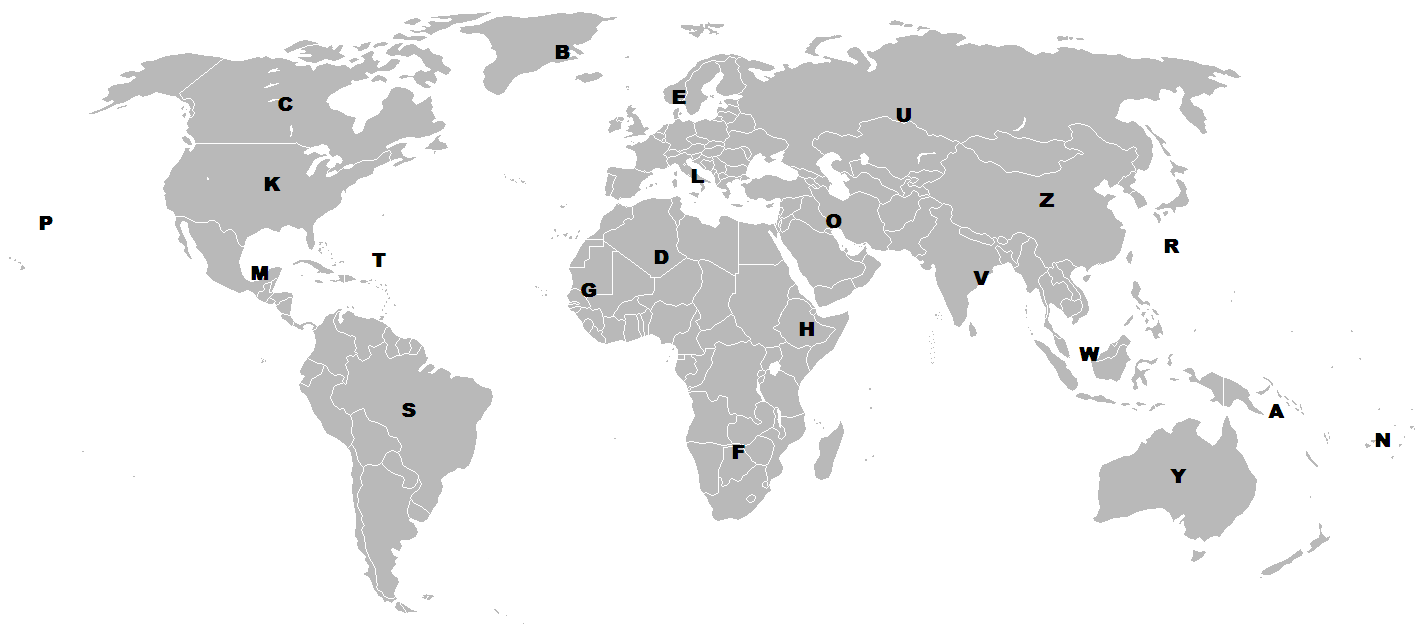

In [6]:
from IPython.display import Image
Image('ICAO-FirstLetter.png')

Prvo ćemo definirati neke funkcije koje će nam biti potrebne za lakše baratanje podacima iz dataframeova. 

In [7]:
def kod(grad):
    a = zrluke.loc[zrluke['City'] == grad]
    ind = a.loc[a['Type'] == 'airport'].index[0]
    kod = zrluke.IATA[ind]
    return kod

In [60]:
kod('Zagreb'), kod('Antwerp')

('ZAG', 'ANR')

Ova funkcija nam iz imena grada daje IATA kod zračne luke u tom gradu.

In [8]:
def broj_ruta(kod):
    r = rute.loc[rute['Destination'] == kod]
    br = r.size/9
    return int(br)

In [61]:
broj_ruta('ZAG'), broj_ruta('ANR')

Funkcija broj_ruta vraća broj ruta koje idu prema zračnoj luci s kodom kod.

In [9]:
def grad(kod):
    a = zrluke.loc[zrluke['IATA'] == kod].index[0]
    grad = zrluke.City[a]
    return grad

Obrnuta funkcija funkciji kod, tj. vraća ime grada za zračnu luku s kodom kod.

In [10]:
def broj_ruta_iz(kod):
    r = rute.loc[rute['Source'] == kod]
    br = r.size/9
    return int(br)

Obrnuta funkcija funkciji broj_ruta, tj. vraća broj ruta iz odabrane zračne luke.

In [11]:
def odkud(kod):
    lista = []
    r = rute.loc[rute['Destination'] == kod]
    for ind in r.index:
        gr = grad(r.Source[ind])
        lista.append(gr)
    return dict.fromkeys(lista).keys() 

In [57]:
odkud('ANR')

dict_keys(['London'])

Vraća neponavljajuću listu gradova iz kojih je moguće doći u zračnu luku s kodom kod.

In [12]:
def koja_kompanija(kod):
    lista = []
    r = rute.loc[rute['Destination'] == kod]
    for ind in r.index:
        ak = r.Airline[ind]
        ind = kompanije.loc[kompanije['IATA'] == ak].index[0]
        lista.append(kompanije.Name[ind])
    return lista

In [58]:
koja_kompanija('ANR')

['Air France', 'CityJet']

Vraća naziv aviokompanije koja ima let u zračnu luku s kodom kod.

In [13]:
import sympy as sp
sp.init_printing()

Pomoću sympy-a ćemo prikazati funkciju za računanje udaljenosti s njihovim koordinatama. $\phi_1$ i $\phi_2$ nam označavaju geografsku širinu, $\lambda$ je razlika geografskih duljina, a $R$ ima vrijednost $6,371$ km

In [14]:
u, R, fi1, fi2, l = sp.symbols('u, R, phi_1, phi_2, lambda')
sp.Eq(u, sp.acos(sp.sin(fi1)*sp.sin(fi2)+sp.cos(fi1)*sp.cos(fi2)*sp.cos(l))*R)

In [15]:
import math
def rad(x):
    return x*math.pi/180

Pomoću te funkcije možemo izračunati koji je smještaj najbliži, a koji najudaljeniji od aerodroma, izraženo u kilometrima.

In [34]:
import operator
ind = zrluke.loc[zrluke['IATA'] == 'DUB'].index[0]
fi1 = rad(zrluke.Latitude[ind])
mini = 6371
maks = 0
for i in dublin.index:
    fi2 = rad(dublin.latitude[i])
    l = rad(zrluke.Longitude[ind] - dublin.longitude[i])
    u = math.acos(math.sin(fi1)*math.sin(fi2)+math.cos(fi1)*math.cos(fi2)*math.cos(l))*6371
    if operator.lt(u, mini):
        mini = u
        fim = fi2
    if operator.gt(u, maks):
        maks = u
        fiM = fi2
mini, maks

Pogledajmo koja je srednja vrijednost geografske širine i duljine te izračunajmo koliko je ta srednja vrijednost udaljena od zračne luke.

In [39]:
import statistics
fi = statistics.mean(dublin.latitude)
l1 = statistics.mean(dublin.longitude)
fi2 = rad(fi)
l = rad(zrluke.Longitude[ind] - l1)
u = math.acos(math.sin(fi1)*math.sin(fi2)+math.cos(fi1)*math.cos(fi2)*math.cos(l))*6371
fi, l1, u

Sada ćemo pomoću Basemap-a, skinutog s https://anaconda.org/conda-forge/basemap prikazati zračne luke u/na odabranim gradovima/otocima i raspoložive smještaje u okolici ili na otoku. Kodovi se ponavljaju jer nije bilo mogućnosti složiti funkciju(promijenjive koordinate i nazivi datoteka s AirB'n'B).
Uz pomoć stranice http://boundingbox.klokantech.com/ određene su koordinate rubova potrebne za inicijalizaciju svakog prikaza. Prvo ćemo na karti svijeta prikzati sve zračne luke iz korištenog dataframe-a.

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

C:\Users\nikol\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
C:\Users\nikol\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


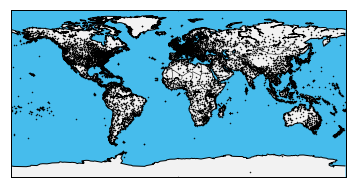

In [54]:
d = Basemap()
d.drawmapboundary(fill_color='#46bcec')
d.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
d.drawcoastlines()
d.drawcountries()
for i in zrluke.index:
    Lat = zrluke.Latitude[i]
    Lon = zrluke.Longitude[i]
    x, y = d(Lon, Lat)
    plt.plot(x, y, 'ok', markersize=0.5)

C:\Users\nikol\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
C:\Users\nikol\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


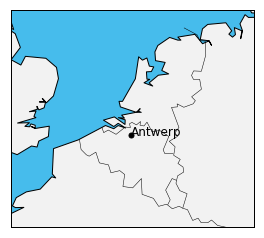

In [18]:
m = Basemap(resolution='l', projection='merc', llcrnrlon= 0, llcrnrlat= 49, urcrnrlon= 9, urcrnrlat= 54)
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()
m.drawcountries()
m.etopo(scale=0.5, alpha=0.5)
a = zrluke.loc[zrluke['IATA'] == 'ANR'].index[0]
Lat = zrluke.Latitude[a]
b = zrluke.loc[zrluke['IATA'] == 'ANR'].index[0]
Lon = zrluke.Longitude[b]
x, y = m(Lon, Lat)
plt.plot(x, y, 'ok', markersize=5)
plt.text(x, y, 'Antwerp', fontsize=12);

C:\Users\nikol\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
C:\Users\nikol\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


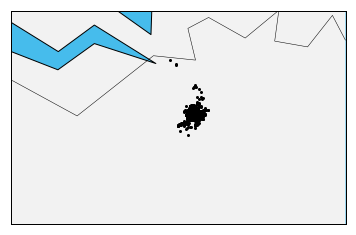

In [19]:
m = Basemap(resolution='l', projection='merc', llcrnrlon= 3.6, llcrnrlat= 50.9, urcrnrlon= 5.1, urcrnrlat= 51.5)
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()
m.drawcountries()
m.etopo(scale=0.5, alpha=0.5)
for i in antwerp.index:
    Lat = antwerp.latitude[i]
    Lon = antwerp.longitude[i]
    x, y = m(Lon, Lat)
    plt.plot(x, y, 'ok', markersize=2)

C:\Users\nikol\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
C:\Users\nikol\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


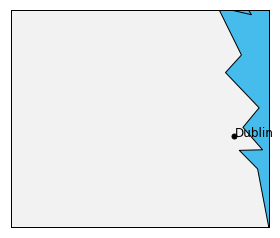

In [20]:
d = Basemap(resolution='l', projection='merc', llcrnrlon= -8, llcrnrlat= 53, urcrnrlon= -6, urcrnrlat= 54)
d.drawmapboundary(fill_color='#46bcec')
d.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
d.drawcoastlines()
d.drawcountries()
d.etopo(scale=0.5, alpha=0.5)
a = zrluke.loc[zrluke['IATA'] == 'DUB'].index[0]
Lat = zrluke.Latitude[a]
b = zrluke.loc[zrluke['IATA'] == 'DUB'].index[0]
Lon = zrluke.Longitude[b]
x, y = d(Lon, Lat)
plt.plot(x, y, 'ok', markersize=5)
plt.text(x, y, 'Dublin', fontsize=12);

C:\Users\nikol\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
C:\Users\nikol\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


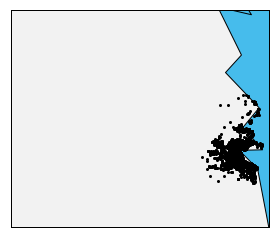

In [21]:
d = Basemap(resolution='l', projection='merc', llcrnrlon= -8, llcrnrlat= 53, urcrnrlon= -6, urcrnrlat= 54)
d.drawmapboundary(fill_color='#46bcec')
d.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
d.drawcoastlines()
d.drawcountries()
d.etopo(scale=0.5, alpha=0.5)
for i in dublin.index:
    Lat = dublin.latitude[i]
    Lon = dublin.longitude[i]
    x, y = d(Lon, Lat)
    plt.plot(x, y, 'ok', markersize=2)

C:\Users\nikol\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
C:\Users\nikol\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


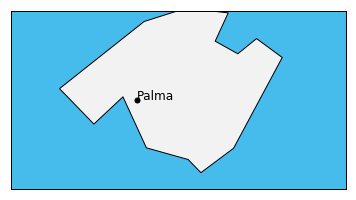

In [22]:
d = Basemap(resolution='l', projection='merc', llcrnrlon=2.1, llcrnrlat=39.2, urcrnrlon=3.8, urcrnrlat=39.9)
d.drawmapboundary(fill_color='#46bcec')
d.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
d.drawcoastlines()
d.drawcountries()
d.etopo(scale=0.5, alpha=0.5)
a = zrluke.loc[zrluke['IATA'] == 'PMI'].index[0]
Lat = zrluke.Latitude[a]
b = zrluke.loc[zrluke['IATA'] == 'PMI'].index[0]
Lon = zrluke.Longitude[b]
x, y = d(Lon, Lat)
plt.plot(x, y, 'ok', markersize=5)
plt.text(x, y, 'Palma', fontsize=12);

In [23]:
len(mallorca.index)

Kako na Mallorci ima preko $14 000$ dostupnih smještaja zbog trajanja prikazano je samo prvih 1500.

C:\Users\nikol\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
C:\Users\nikol\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


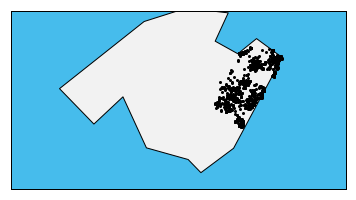

In [24]:
d = Basemap(resolution='l', projection='merc', llcrnrlon=2.1, llcrnrlat=39.2, urcrnrlon=3.8, urcrnrlat=39.9)
d.drawmapboundary(fill_color='#46bcec')
d.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
d.drawcoastlines()
d.drawcountries()
d.etopo(scale=0.5, alpha=0.5)
for i in range (0, 1500):
    Lat = mallorca.latitude[i]
    Lon = mallorca.longitude[i]
    x, y = d(Lon, Lat)
    plt.plot(x, y, 'ok', markersize=2)

C:\Users\nikol\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
C:\Users\nikol\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


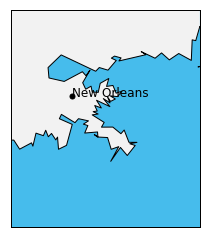

In [25]:
d = Basemap(resolution='l', projection='merc', llcrnrlon= -91, llcrnrlat= 28, urcrnrlon= -88, urcrnrlat= 31)
d.drawmapboundary(fill_color='#46bcec')
d.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
d.drawcoastlines()
d.drawcountries()
d.etopo(scale=0.5, alpha=0.5)
a = zrluke.loc[zrluke['IATA'] == 'NBG'].index[0]
Lat = zrluke.Latitude[a]
b = zrluke.loc[zrluke['IATA'] == 'NBG'].index[0]
Lon = zrluke.Longitude[b]
x, y = d(Lon, Lat)
plt.plot(x, y, 'ok', markersize=5)
plt.text(x, y, 'New Orleans', fontsize=12);

C:\Users\nikol\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
C:\Users\nikol\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


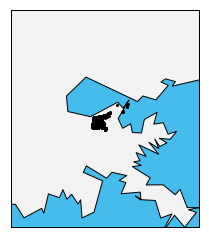

In [26]:
d = Basemap(resolution='l', projection='merc', llcrnrlon= -91, llcrnrlat= 29, urcrnrlon= -89, urcrnrlat= 31)
d.drawmapboundary(fill_color='#46bcec')
d.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
d.drawcoastlines()
d.drawcountries()
d.etopo(scale=0.5, alpha=0.5)
for i in new_orleans.index:
    Lat = new_orleans.latitude[i]
    Lon = new_orleans.longitude[i]
    x, y = d(Lon, Lat)
    plt.plot(x, y, 'ok', markersize=2)

C:\Users\nikol\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
C:\Users\nikol\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


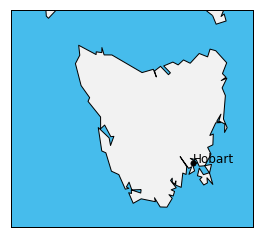

In [27]:
d = Basemap(resolution='l', projection='merc', llcrnrlon= 143, llcrnrlat= -44, urcrnrlon= 149, urcrnrlat= -40)
d.drawmapboundary(fill_color='#46bcec')
d.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
d.drawcoastlines()
d.drawcountries()
d.etopo(scale=0.5, alpha=0.5)
a = zrluke.loc[zrluke['IATA'] == 'HBA'].index[0]
Lat = zrluke.Latitude[a]
b = zrluke.loc[zrluke['IATA'] == 'HBA'].index[0]
Lon = zrluke.Longitude[b]
x, y = d(Lon, Lat)
plt.plot(x, y, 'ok', markersize=5)
plt.text(x, y, 'Hobart', fontsize=12);

C:\Users\nikol\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
C:\Users\nikol\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


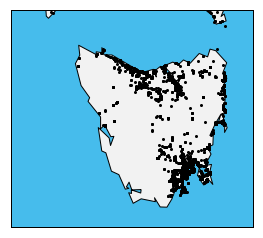

In [28]:
d = Basemap(resolution='l', projection='merc', llcrnrlon= 143, llcrnrlat= -44, urcrnrlon= 149, urcrnrlat= -40)
d.drawmapboundary(fill_color='#46bcec')
d.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
d.drawcoastlines()
d.drawcountries()
d.etopo(scale=0.5, alpha=0.5)
for i in tasmania.index:
    Lat = tasmania.latitude[i]
    Lon = tasmania.longitude[i]
    x, y = d(Lon, Lat)
    plt.plot(x, y, 'ok', markersize=2)

Gore je izračunata srednja udaljenost smještaja za Dublin. Vidimo da su na Tasmaniji smještaji raštrkaniji pa ćemo taj kod ponoviti.

In [40]:
ind = zrluke.loc[zrluke['IATA'] == 'HBA'].index[0]
fi1 = rad(zrluke.Latitude[ind])
mini = 6371
maks = 0
for i in tasmania.index:
    fi2 = rad(tasmania.latitude[i])
    l = rad(zrluke.Longitude[ind] - tasmania.longitude[i])
    u = math.acos(math.sin(fi1)*math.sin(fi2)+math.cos(fi1)*math.cos(fi2)*math.cos(l))*6371
    if operator.lt(u, mini):
        mini = u
        fim = fi2
    if operator.gt(u, maks):
        maks = u
        fiM = fi2
mini, maks

In [41]:
fi = statistics.mean(tasmania.latitude)
l1 = statistics.mean(tasmania.longitude)
fi2 = rad(fi)
l = rad(zrluke.Longitude[ind] - l1)
u = math.acos(math.sin(fi1)*math.sin(fi2)+math.cos(fi1)*math.cos(fi2)*math.cos(l))*6371
fi, l1, u

Statistički program u Pythonu nam omogućuje i računanje prosječnih cijena smještaja. Također možemo izračunati i najčešću cijenu.

In [46]:
statistics.mean(new_orleans.price)

In [45]:
statistics.mode(new_orleans.price)

In [47]:
statistics.mode(mallorca.price)

In [48]:
statistics.mean(mallorca.price)

Vidimo da je Mallorca puno jeftinija od New Orleansa i po najčešćoj cijeni i po prosječnoj cijeni.